## Imports

In [86]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

## Read Model Matrix Data

In [7]:
labeled_m = pd.read_csv('/mnt/data/shared/workingData/unemployment_data_matrix.csv')

/opt/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (23,35,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
labeled_m.head()

,ute_id,application_id,cancelled_before_12mo,placed_before_12mo,ltu,application,cancellation,category_change,convocation,intervention,...,conjuge_estado_civil,conjuge_categoria,conjuge_estado,conjuge_motivo_indisponibilidade,candidatura_categoria_anterior,candidatura_estado_anterior,ute_nr_pessoas_cargo,ute_nr_descendentes_cargo,candidatura_data_ppe,app_start_date
0,818,70845,False,False,True,1.0,1.0,NaN,9.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,2013-02-01
1,820,22603,False,False,True,1.0,1.0,1.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2009-03-01
2,820,61013,True,False,False,1.0,1.0,NaN,3.0,1.0,...,NaN,NaN,NaN,NaN,3.0,PAS,2.0,2.0,NaN,2012-05-01
3,832,1930,False,True,False,1.0,NaN,NaN,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2007-03-01
4,832,9174,True,False,False,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2007-12-01


In [12]:
labeled_m.columns

Index([u'ute_id', u'application_id', u'cancelled_before_12mo',
       u'placed_before_12mo', u'ltu', u'application', u'cancellation',
       u'category_change', u'convocation', u'intervention', u'interview',
       u'table_index', u'anomes', u'ctipo_movimento', u'dtipo_movimento',
       u'sexo', u'chabilitacao_escolar', u'dhabilitacao_escolar',
       u'cdeficiencia', u'ddeficiencia', u'cnacionalidade', u'dnacionalidade',
       u'cnp_pretendida', u'dcnp_pretendida', u'cpp_pretendida',
       u'dcpp_pretendida', u'candidatura_data', u'ccategoria', u'dcategoria',
       u'candidatura_motivo_inscricao', u'candidatura_rinsc',
       u'ute_estado_civil', u'candidatura_int_tempo_nao_insc',
       u'candidatura_prof_pret_tempo_pratica',
       u'sit_anterior_prof_tempo_pratica', u'candidatura_local_trabalho',
       u'ute_plano_emprego', u'ute_plano_emprego_anterior',
       u'candidatura_carteira_prof', u'candidatura_formacao_prof',
       u'candidatura_qualificacao', u'reinscricao_ult_sai

## Select Features

In [33]:
model_m = labeled_m.copy()
model_m = model_m[['application_id','app_start_date','sexo','ute_idade','sub_rsi','ltu']]
model_m['app_start_date'] = pd.to_datetime(model_m['app_start_date'])
model_m = pd.get_dummies(model_m, columns=['sexo','sub_rsi'])
model_m.head()

,application_id,app_start_date,ute_idade,ltu,sexo_F,sexo_M,sub_rsi_N,sub_rsi_S
0,70845,2013-02-01,50,True,1,0,1,0
1,22603,2009-03-01,39,True,1,0,1,0
2,61013,2012-05-01,42,False,1,0,1,0
3,1930,2007-03-01,32,False,0,1,1,0
4,9174,2007-12-01,33,False,0,1,1,0


In [35]:
type(model_m['app_start_date'][0])

pandas._libs.tslib.Timestamp

## Define Model input/output

In [47]:
y = model_m.ltu.astype(float)
X = model_m.drop('ltu', 1)

In [23]:
estimator = sklearn.ensemble.RandomForestClassifier(n_estimators=100,
                       criterion='gini',
                       max_depth=None,
                       random_state=4321) # always set your random seed for reproducibility!
estimator.fit(X=X, y=y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=4321,
            verbose=0, warm_start=False)

## Temporal Split

In [88]:
def split_data(data_matrix,test_date,train_timedelta,test_timedelta):
    m_train = data_matrix[(data_matrix['app_start_date'] >= test_date - train_timedelta) & (data_matrix['app_start_date'] < test_date)].sort_values('app_start_date').drop('app_start_date',1)
    m_test = data_matrix[(data_matrix['app_start_date'] >= test_date) & (data_matrix['app_start_date'] < test_date + test_timedelta)].sort_values('app_start_date').drop('app_start_date',1)
    
    return m_train, m_test

m_train, m_test = split_data(data_matrix=model_m,
                             test_date=pd.to_datetime('2015-04-30'),
                             train_timedelta=pd.Timedelta('730D'),
                             test_timedelta=pd.Timedelta('365D'))

In [89]:
m_train.head()

,application_id,ute_idade,ltu,sexo_F,sexo_M,sub_rsi_N,sub_rsi_S
67677,74506,23,True,0,1,1,0
30156,74241,33,True,0,1,1,0
18769,74138,33,False,0,1,1,0
25433,74192,62,True,0,1,1,0
7801,74044,58,True,0,1,1,0


In [90]:
m_test.head()

,application_id,ute_idade,ltu,sexo_F,sexo_M,sub_rsi_N,sub_rsi_S
59775,100608,54,False,0,1,1,0
18489,100302,48,False,1,0,1,0
85815,100765,29,False,1,0,1,0
28533,100374,48,False,1,0,1,0
104924,100963,34,False,0,1,0,1


In [91]:
print(m_train.shape)
print(m_test.shape)

(25399, 7)
(12524, 7)


## Predict

In [92]:
estimator.fit(X=m_train.drop('ltu',1), y=m_train.ltu.astype(float))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=4321,
            verbose=0, warm_start=False)

In [93]:
pred = estimator.predict_proba(X=m_test.drop('ltu',1)) # not all classifiers have predict_proba

In [94]:
pred

array([[ 0.76,  0.24],
       [ 0.24,  0.76],
       [ 0.79,  0.21],
       ..., 
       [ 0.9 ,  0.1 ],
       [ 0.99,  0.01],
       [ 0.99,  0.01]])

In [95]:
pred = pd.Series(index=m_test.index, data=pred[:,1])

## Evaluate

In [96]:
sklearn.metrics.roc_auc_score(m_test.ltu, pred)

0.58407305875767002

In [97]:
# sklearn.metrics to the rescue!
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true=m_test.ltu,probas_pred=pred)

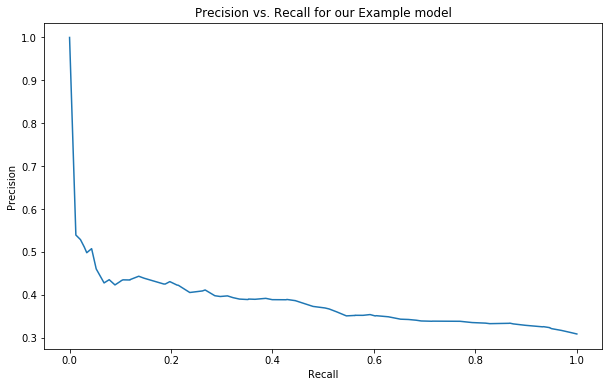

In [98]:
# first, let's plot precision vs recall
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(recall_curve, precision_curve)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision vs. Recall for our Example model')
plt.show()

In [99]:
def plot_precision_recall_n(y_true, y_prob, model_name, **kwargs): # kwargs to the rescue
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots(**kwargs)
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('ratio of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf()

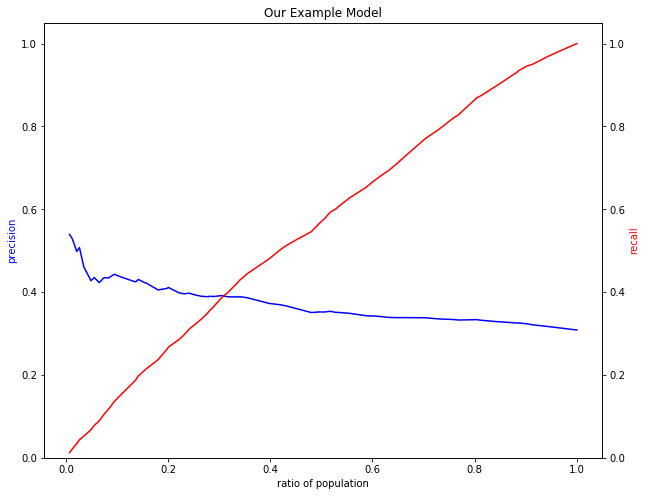

In [100]:
plot_precision_recall_n(y_true=m_test.ltu,
                        y_prob=pred,
                        model_name='Our Example Model',
                        figsize=(10,8)) # <-- figsize is a kwarg now, we pass it through to the plotting function